# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [51]:
# import libraries
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
import time

In [52]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [53]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [54]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [55]:
df.count()

286500

### Drop null value

In [56]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



The number of null value in ```artist```, ```length``` and ```song``` are same

In [57]:
# Check empty value

In [58]:
df.filter(df['userId']=='').count()

8346

In [59]:
df.filter(df['sessionId']=='').count()

0

### Clean the table

In [60]:
df_clean = df.filter(df['userId']!='')

In [61]:
# Check the table
df_clean.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



As I mentioned above the null records in ```artists```, ```length``` and ```song``` column are same. Because these ones can be linked to user interactions without the user playing a song, I won't remove them.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [62]:
# create a new column named "Churn"
df = df.withColumn("Churn", F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0))

In [63]:
# Define window bounds for churn
window_churn = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("total_churn", F.sum("Churn").over(window_churn))

In [64]:
df.filter(F.col("Churn") == 1).sort("total_churn", ascending=False).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+-----------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn|total_churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+-----------+
|  null|Cancelled|    Mason|     M|           10|    Hart|  null| free|  Corpus Christi, TX|   GET|Cancellation Conf...|1533157139000|      174|null|   200|1539318918000|"Mozilla/5.0 (Mac...|   125|    1|          1|
|  null|Cancelled|    Ethan|     M|          176| Johnson|  null| paid|Lexington-Fayette...|   GET|Cancellation Conf...|153808098700

In [65]:
df.groupBy("Churn").count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1|    52|
|    0|286448|
+-----+------+



In [66]:
# Number of interactions users 
df.dropDuplicates(['userId']).groupby(['total_churn']).count().sort("total_churn").show()

+-----------+-----+
|total_churn|count|
+-----------+-----+
|          0|  174|
|          1|   52|
+-----------+-----+



In [67]:
gender = df.select("userId", 'gender', 'Churn').distinct()
gender_df = gender.groupby(['Churn', 'gender']).count().sort('Churn').toPandas()

In [68]:
gender_df.head(5)

,Churn,gender,count
0,0,M,121
1,0,F,104
2,0,None,1
3,1,F,20
4,1,M,32


In [69]:
gender_df.dropna()

,Churn,gender,count
0,0,M,121
1,0,F,104
3,1,F,20
4,1,M,32


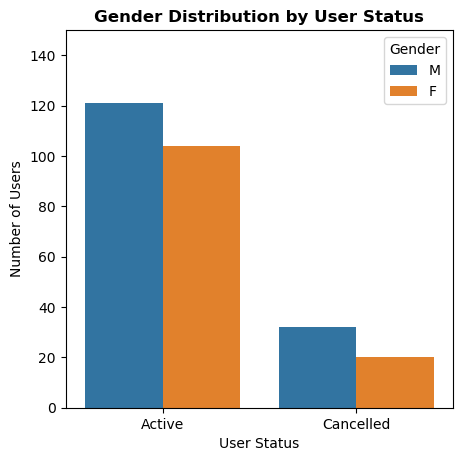

In [70]:
orders = ["Active","Cancelled"]
fig, ax = plt.subplots(figsize = (5,5), dpi = 100);
sns.barplot(data=gender_df, x='Churn', y='count', hue='gender');
plt.ylim([0,150]);
plt.title("Gender Distribution by User Status", fontweight='bold');
plt.xlabel("User Status");
plt.ylabel("Number of Users");
plt.xticks(np.arange(len(orders)), orders)
plt.legend(title='Gender');

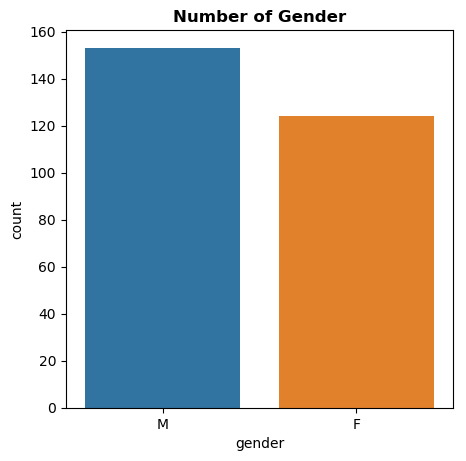

In [71]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 100);
df_gender_count = gender.select('gender').toPandas()
ax = sns.countplot(x='gender', data=df_gender_count)
plt.title("Number of Gender", fontweight='bold');

In [72]:
level = df.select('userId', 'level', 'Churn').distinct()
level_df = level.groupby(['Churn', 'level']).count().sort('Churn').toPandas()

In [73]:
level_df.head(5)

,Churn,level,count
0,0,free,196
1,0,paid,166
2,1,paid,31
3,1,free,21


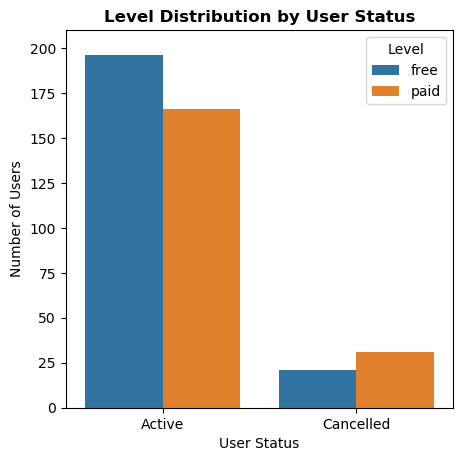

In [74]:
orders = ["Active","Cancelled"]
fig, ax = plt.subplots(figsize = (5,5), dpi = 100);
sns.barplot(data=level_df, x='Churn', y='count', hue='level');
plt.ylim([0,210]);
plt.title("Level Distribution by User Status", fontweight='bold');
plt.xlabel("User Status");
plt.ylabel("Number of Users");
plt.xticks(np.arange(len(orders)), orders)
plt.legend(title='Level');

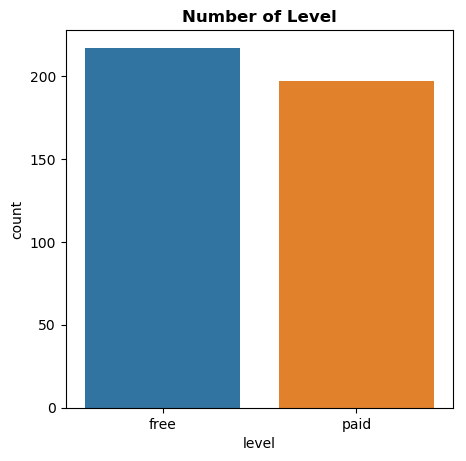

In [75]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 100);
df_level_count = level.select('level').toPandas()
ax = sns.countplot(x='level', data=df_level_count)
plt.title("Number of Level", fontweight='bold');

#### Top5 artist have most played song

In [76]:
top5_artists = df.select('artist').rdd.flatMap(lambda x: x).collect()

In [77]:
pd_artist = df.toPandas()
pd_artist['artist'].value_counts()[:5]

Kings Of Leon             1841
Coldplay                  1813
Florence + The Machine    1236
Dwight Yoakam             1135
BjÃÂ¶rk                  1133
Name: artist, dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

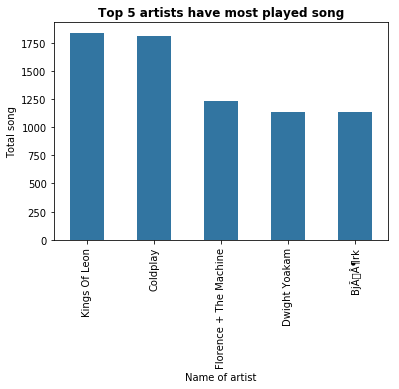

In [78]:
pd_artist['artist'].value_counts()[:5].plot(kind='bar',color = '#3275a1')
plt.title('Top 5 artists have most played song', fontweight='bold')
plt.xlabel("Name of artist");
plt.ylabel("Total song");
plt.xticks(rotation = 90)

#### Top 5 first name

In [79]:
pd_artist['firstName'].value_counts()[:5]

Payton    9632
Riley     7970
Lucero    6880
Emilia    5732
Emma      5478
Name: firstName, dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

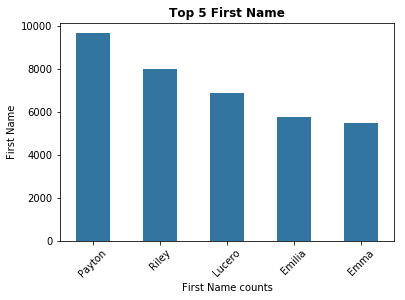

In [80]:
pd_artist['firstName'].value_counts()[:5].plot(kind='bar', color = '#3275a1')
plt.title('Top 5 First Name', fontweight='bold')
plt.xlabel("First Name counts");
plt.ylabel("First Name");
plt.xticks(rotation = 45)

#### Top 5 last name

In [81]:
pd_artist['lastName'].value_counts()[:5]

Campbell    14060
Reed         9284
Williams     8410
Taylor       7230
Johnson      6106
Name: lastName, dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

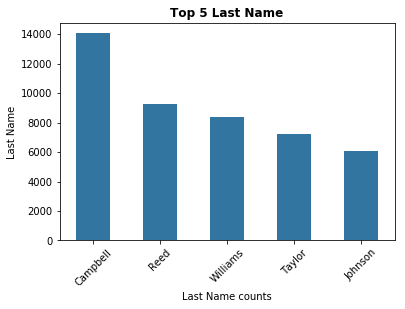

In [45]:
pd_artist['lastName'].value_counts()[:5].plot(kind='bar', color = '#3275a1')
plt.title('Top 5 Last Name', fontweight='bold')
plt.xlabel("Last Name counts");
plt.ylabel("Last Name");
plt.xticks(rotation = 45)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [83]:
# Create user dataframe
df_feature = df.select('userId', 'level', 'gender', 'Churn', 'ts', 'length', 'artist', 'song', 'page')
df_user = df_feature.groupBy('userId').agg(
    F.avg('length').alias('avg_song_length'),
    F.countDistinct('artist').alias('total_artist'),
    F.countDistinct('song').alias('total_song'),
    F.count('page').alias('total_session'),
    F.count(F.when(F.col('page') == 'Thumbs Up', True)).alias('total_thumb_up'),
    F.count(F.when(F.col('page') == 'Thumbs Down', True)).alias('total_thumb_down'),
    F.count(F.when(F.col('page') == 'Add Friend', True)).alias('total_add_friend'),
    F.count(F.when(F.col('page') == 'Add to Playlist', True)).alias('total_add_playlist')
)
df_user.show(5)

+------+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+
|userId|   avg_song_length|total_artist|total_song|total_session|total_thumb_up|total_thumb_down|total_add_friend|total_add_playlist|
+------+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+
|100010|  243.421444909091|         252|       269|          381|            17|               5|               4|                 7|
|200002|242.91699209302305|         339|       378|          474|            21|               6|               4|                 8|
|   125|261.13913750000006|           8|         8|           11|             0|               0|               0|                 0|
|    51|247.88055082899118|        1385|      1854|         2464|           100|              21|              28|                52|
|   124|248.17653659965674|        2232|      3339|         48

In [84]:
label = df.select('userId', F.col('total_churn').alias('label')).dropDuplicates()

In [86]:
# join and drop NaN valua
data = df_user.join(label, "userId").drop("userId")
data = data.dropna()

In [87]:
final_data = data.toPandas()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


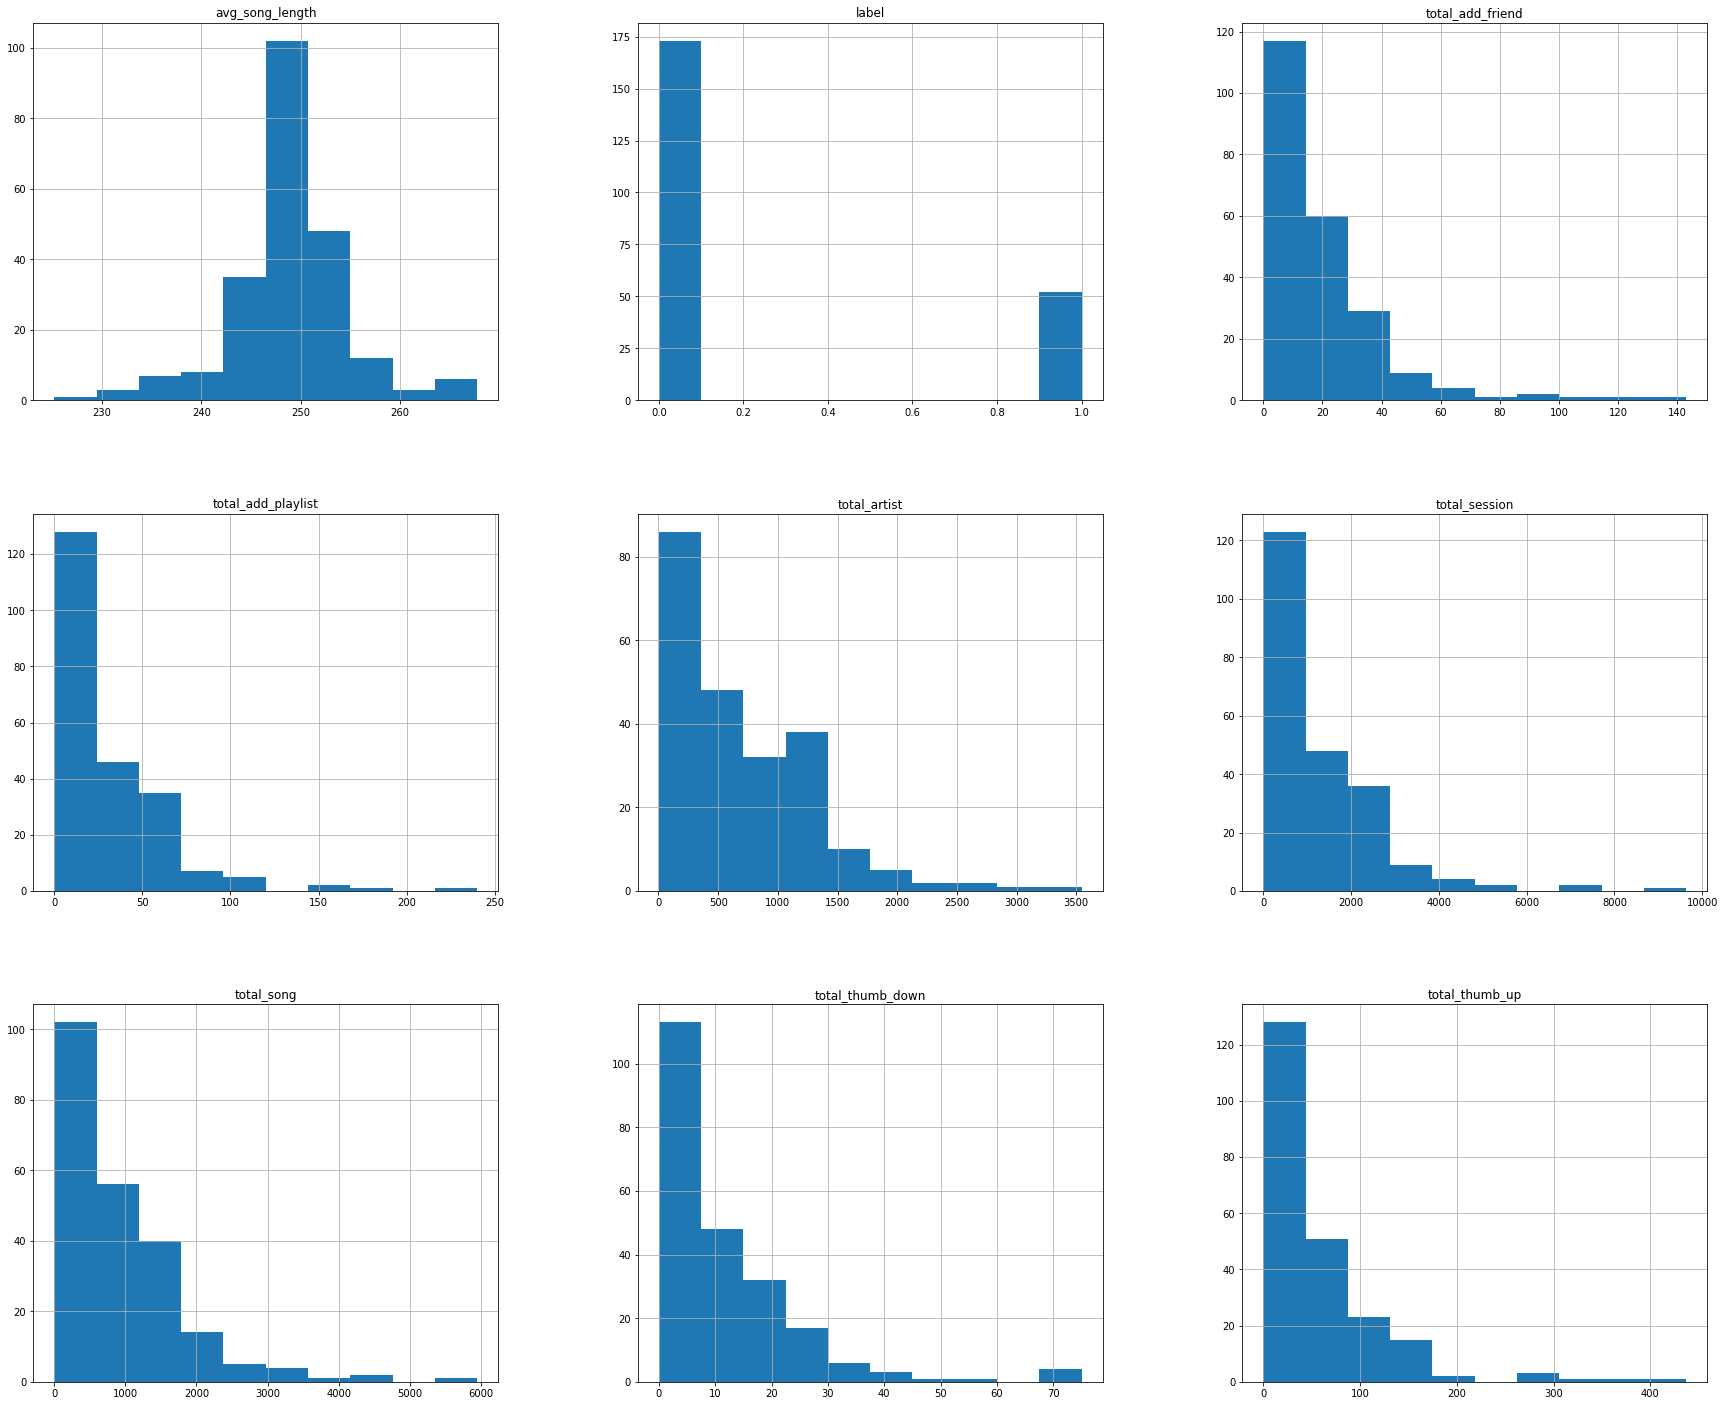

In [88]:
fig = plt.figure(figsize=(30, 25))
ax = fig.gca()
h = final_data.hist(ax=ax)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [89]:
feature_col = data.columns
feature_col.remove("label")

In [90]:
# split the data to 70% training and 30% testing, set random seed to 12.
train, test = data.randomSplit([0.7, 0.3], seed=12)

In [91]:
def build_model(classifier, param):
    """
    Build the classfication model with Cross Validation
    
    Parameters:
    classifier: Model
    param: parameter tuning for the model
    
    Returns:
    Classfication model
    """
    # create a vector for the features
    assembler = VectorAssembler(inputCols=feature_col, outputCol="features_vec")
    # normalize the Vectors
    scaler = Normalizer(inputCol="features_vec", outputCol="features")
    # build the Pipeline with cross validation
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='label', metricName='f1'),
        numFolds=5,
    )
    return model

In [92]:
def evaluate_model(pred):
    """ Model evaluation with F1 score metric """
    
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    print('F1 score: {}'.format(f1_score))

#### Logistic Regression

In [94]:
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_param = ParamGridBuilder().build()
lr_model = build_model(lr, lr_param)

In [95]:
start_time = time.time()
lr_fit_model = lr_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 815.1916043758392


In [96]:
pred = lr_fit_model.transform(test)

In [97]:
evaluate_model(pred)

F1 score: 0.6611704834605598


#### Random Forest

In [98]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [99]:
start_time = time.time()
rf_fit_model = rf_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 338.4711871147156


In [100]:
rf_pred = rf_fit_model.transform(test)

In [101]:
evaluate_model(rf_pred)

F1 score: 0.6810188261351051


#### Gradient Boosting

In [103]:
gbt = GBTClassifier(featuresCol="features", labelCol="label")
gbt_param = ParamGridBuilder().build()
gbt_model = build_model(gbt, gbt_param)

In [104]:
start_time = time.time()
gbt_fit_model = gbt_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 1359.4430031776428


In [105]:
gbt_pred = gbt_fit_model.transform(test)

In [106]:
evaluate_model(gbt_pred)

F1 score: 0.6732326398784079


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.